*It's a method used to determine customer value by looking at three dimensions:*

- **Recency**: When is the last time the user takes an action? 
- **Frequency**: How many times does the user take this action?
- **Monetary**: What is the sum of monetary value from this user throughout his/her lifetime?

- *Recency : the interval between the **last action** and **today***
- *Frequency : the number of action between the user's **signup date** and **today***
- *Monetary : the sum of revenue within the user's lifetime*

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:/Users/emirh/OneDrive/Belgeler/GitHub/CRM/RFM_analysis/online_retail_listing.csv",delimiter=";",encoding="unicode_escape")

In [3]:
def check_df(df):
    print("---------------- Shape ----------------")
    print(df.shape)
    print("---------------- Columns ----------------")
    print(df.columns)
    print("---------------- Types ----------------")
    print(df.dtypes)
    print("---------------- Head ----------------")
    print(df.head())
    print("---------------- Tail ----------------")
    print(df.tail())
    print("---------------- Describe ----------------")
    print(df.describe().T)

check_df(df)    

---------------- Shape ----------------
(1048575, 8)
---------------- Columns ----------------
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
---------------- Types ----------------
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price           object
Customer ID    float64
Country         object
dtype: object
---------------- Head ----------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 

In [4]:
df["Price"] = df["Price"].str.replace(",",".").astype("float64")

In [5]:
df.Price.dtype

dtype('float64')

In [6]:
df["Total_Price"] = df["Quantity"] * df["Price"]
df["Total_Price"].head()

0     83.4
1     81.0
2     81.0
3    100.8
4     30.0
Name: Total_Price, dtype: float64

### Top 5 Most Ordered Product

<AxesSubplot:title={'center':'Top 5 Ordered Product'}, ylabel='Description'>

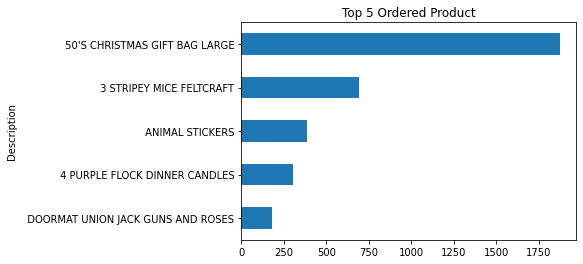

In [7]:
(df
.groupby(["Description"])
.Quantity
.sum()
.head()
.sort_values()
.plot(kind="barh",title="Top 5 Ordered Product"))

### Top 5 Expensive Product

<AxesSubplot:title={'center':'Top 5 Expensive Product'}, xlabel='Description'>

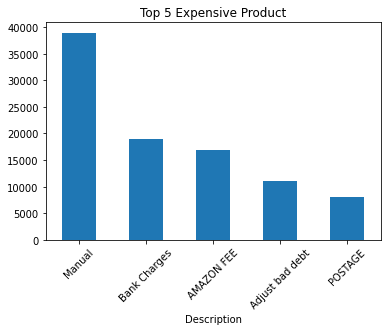

In [8]:
(df
.groupby("Description")
.Price
.max()
.sort_values(ascending=False)
.head()
.plot(kind="bar",rot=45,title= "Top 5 Expensive Product")
)

### How many orders came from which country?

<AxesSubplot:title={'center':'Top 5 Ordered Countries'}>

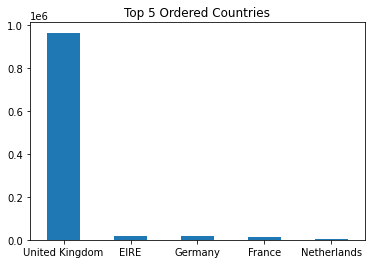

In [9]:
(df
.Country
.value_counts()
.head()
.plot(kind="bar",rot=0,title="Top 5 Ordered Countries")
)

### The invoice with the most expensive purchase

<AxesSubplot:title={'center':'Most Expensive Purchase'}, xlabel='Invoice'>

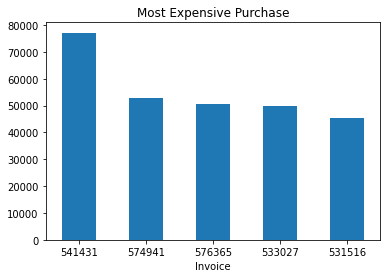

In [10]:
(df
.groupby("Invoice")
.Total_Price
.sum()
.sort_values(ascending=False)
.head()
.plot(kind="bar",rot=0,title="Most Expensive Purchase")
)

## Missing data analysis

In [11]:
(df
.isna()
.mean()
.mul(100))

Invoice         0.000000
StockCode       0.000000
Description     0.416947
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.571776
Country         0.000000
Total_Price     0.000000
dtype: float64

In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Total_Price    0
dtype: int64

## Outlier Engineering

<AxesSubplot:>

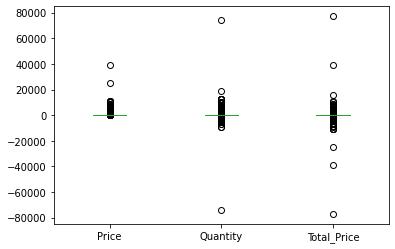

In [14]:
df[["Price","Quantity","Total_Price"]].plot(kind="box")


In [15]:
def outlier(data,col):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lower = data[col].quantile(0.25) - (IQR * 1.5)
    upper  = data[col].quantile(0.75) + (IQR * 1.5)
    b_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"Total Outliers of the {col} : {b_total}")
    df[col] = np.where(df[col]<lower,lower,np.where(df[col]>upper,upper,data[col]))
    a_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"(After Replacement) Total Outliers of the {col} : {a_total}")

In [16]:
for col in ["Quantity","Price","Total_Price"]:
    outlier(df,col)

Total Outliers of the Quantity : 53226
(After Replacement) Total Outliers of the Quantity : 0
Total Outliers of the Price : 70281
(After Replacement) Total Outliers of the Price : 0
Total Outliers of the Total_Price : 68158
(After Replacement) Total Outliers of the Total_Price : 0


### How many unique items in the dataset?

In [17]:
df["Description"].nunique()

5297

### Remove the canceled transactions from the dataset


In [18]:
df = df[~df["Invoice"].str.contains("C", na=False)]

### Drop duplicate

In [19]:
df.drop_duplicates(subset=["Invoice", "Customer ID"], keep="first", inplace=True)


## Calculating of RFM metrics

In [20]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max() # last purchase '9.12.2010 20:01'
today_date = dt.datetime(2012,1,1)


In [21]:
rfm = df.groupby("Customer ID").agg(
    {"InvoiceDate" : lambda date: (today_date - date.max()).days,
    "Invoice" : lambda num: len(num),
    "Total_Price": lambda  TotalPrice: TotalPrice.sum()}
)
rfm.columns=["Recency","Frequency","Monetary"]

In [22]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,5863.0,233.085622,213.814489,21.0,51.0,142.000,401.0000,1083.00
Frequency,5863.0,6.219171,12.860518,1.0,1.0,3.000,7.0000,391.00
Monetary,5863.0,132.694303,337.015846,0.0,20.4,52.575,127.1875,9562.18


In [23]:
rfm["R_Score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm["R_Score"].astype(str) +rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346.0,347,12,253.990,2,5,5,255
12347.0,61,7,160.835,4,4,5,445
12348.0,97,5,179.310,3,4,5,345
12349.0,40,4,95.025,5,3,4,534
12350.0,332,1,25.200,2,1,2,212


In [26]:
seg_map = {
    r'[1-2][1-2]': "Hibernating",
    r'[1-2][3-4]': "At Risk",
    r'[1-2]5': "Can\'t Loose",
    r'3[1-2]': "About to Sleep",
    r'33': "Need Attention",
    r'[3-4][4-5]': "Loyal Customers",
    r'41': "Promising",
    r'51': "New Customers",
    r'[4-5][2-3]': "Potential Loyalists",
    r'5[4-5]': "Champions"
}

rfm['Segment'] = rfm['RFM_Score'].replace(seg_map, regex=True)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,347,12,253.990,2,5,5,255,Can't Loose5
12347.0,61,7,160.835,4,4,5,445,Loyal Customers5
12348.0,97,5,179.310,3,4,5,345,Loyal Customers5
12349.0,40,4,95.025,5,3,4,534,5Loyal Customers
12350.0,332,1,25.200,2,1,2,212,Hibernating2
